In [1]:
# Google Colab / local environment - Install PySpark
!pip install pyspark
!apt install openjdk-11-jdk-headless -qq > /dev/null

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("BoneAgePrediction") \
    .config("spark.sql.warehouse.dir", "/user/hive/warehouse") \
    .config("spark.sql.catalogImplementation", "in-memory") \
    .getOrCreate()

In [11]:
import zipfile
import os

# Path to already uploaded ZIP file
zip_path = "/content/dataset1.zip"

# Extract to target directory
extract_path = "/content/dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Confirm extraction
print("Extracted folders:", os.listdir(extract_path))

Extracted folders: ['boneage-training-dataset', 'boneage-test-dataset']


In [3]:
# If you've uploaded boneage-training-dataset.csv to Colab:
metadata_path = "/content/boneage-training-dataset.csv"

# Read metadata
df = spark.read.csv(metadata_path, header=True, inferSchema=True)
df.printSchema()
df.show(5)

root
 |-- id: integer (nullable = true)
 |-- boneage: integer (nullable = true)
 |-- male: boolean (nullable = true)

+----+-------+-----+
|  id|boneage| male|
+----+-------+-----+
|1377|    180|false|
|1378|     12|false|
|1379|     94|false|
|1380|    120| true|
|1381|     82|false|
+----+-------+-----+
only showing top 5 rows



In [5]:
from pyspark.sql.functions import when, col

# Convert gender to binary
df = df.withColumn("GenderEncoded", when(col("male") == 1, 1).otherwise(0))

# Select required features
df_selected = df.select("boneage", "GenderEncoded")
df_selected.show(5)


+-------+-------------+
|boneage|GenderEncoded|
+-------+-------------+
|    180|            0|
|     12|            0|
|     94|            0|
|    120|            1|
|     82|            0|
+-------+-------------+
only showing top 5 rows



In [6]:
df_pd = df_selected.toPandas()

# Drop rows with missing values (if any)
df_pd.dropna(inplace=True)

X = df_pd[["GenderEncoded"]]
y = df_pd["boneage"]

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)


In [8]:
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Random Forest Evaluation:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.2f}")


Random Forest Evaluation:
RMSE: 40.84
MAE: 32.87
R² Score: 0.06


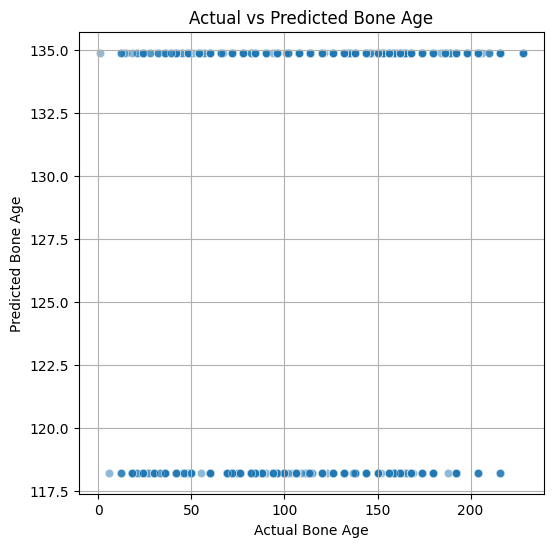

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot: true vs predicted
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.xlabel("Actual Bone Age")
plt.ylabel("Predicted Bone Age")
plt.title("Actual vs Predicted Bone Age")
plt.grid(True)
plt.show()


In [10]:
# Register Temp View
df.createOrReplaceTempView("boneage_table")

# Example Query
query = spark.sql("SELECT GenderEncoded, AVG(boneage) as AvgBoneAge FROM boneage_table GROUP BY GenderEncoded")
query.show()


+-------------+------------------+
|GenderEncoded|        AvgBoneAge|
+-------------+------------------+
|            1| 135.3036733499195|
|            0|117.88023537556248|
+-------------+------------------+



In [14]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

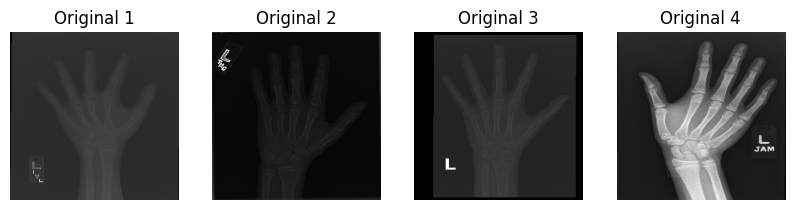

In [20]:
# Path to training image directory
image_dir = "/content/dataset/boneage-training-dataset"

# List image filenames
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png') or f.endswith('.jpg')]

# Load 3 sample images
sample_imgs = [load_img(os.path.join(image_dir, image_files[i]), target_size=(256, 256)) for i in range(4)]
plt.figure(figsize=(10, 4))
for i, img in enumerate(sample_imgs):
    plt.subplot(1, 4, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"Original {i+1}")
plt.show()


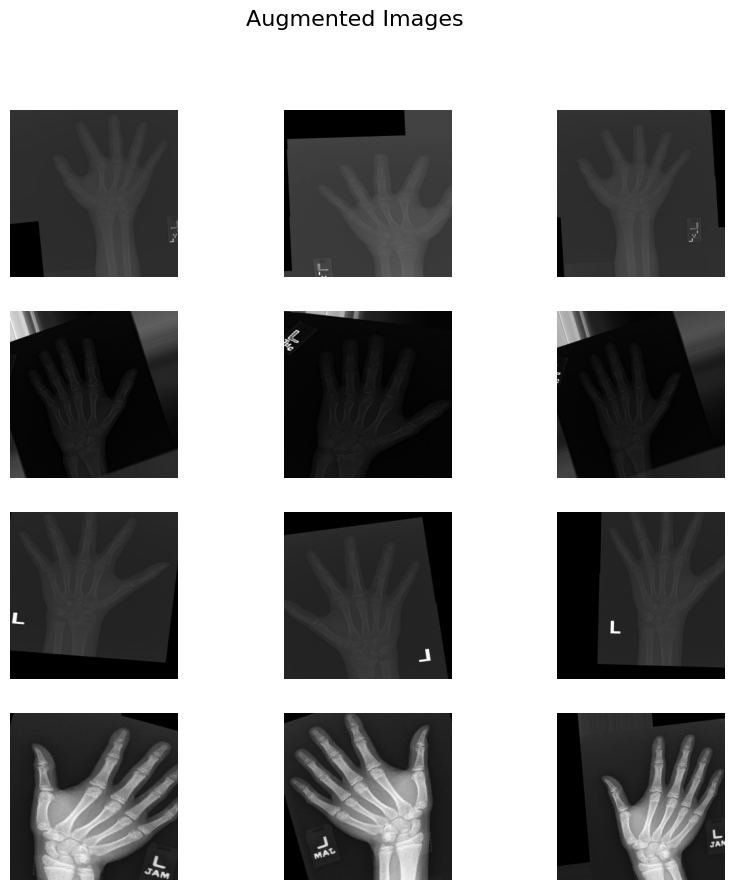

In [21]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
plt.figure(figsize=(10, 10))
for i, img in enumerate(sample_imgs):
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    # Generate 3 augmented images per original
    aug_iter = datagen.flow(x, batch_size=1)

    for j in range(3):
        aug_img = next(aug_iter)[0].astype("uint8")
        plt.subplot(len(sample_imgs), 3, i*3 + j + 1)
        plt.imshow(array_to_img(aug_img), cmap='gray')
        plt.axis('off')
plt.suptitle("Augmented Images", fontsize=16)
plt.show()


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

In [24]:
# Load the labels CSV
df = pd.read_csv('/content/boneage-training-dataset.csv')

# Add .png to the ID column
df['id'] = df['id'].astype(str) + '.png'

# Optional: Normalize bone age
df['boneage'] = df['boneage'] / df['boneage'].max()

# Split into train and validation
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Set paths
img_dir = '/content/boneage-training-dataset/'

In [26]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1)  # Output layer for regression
])

model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,665 (12.61 MB)

 Trainable params: 3,305,217 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

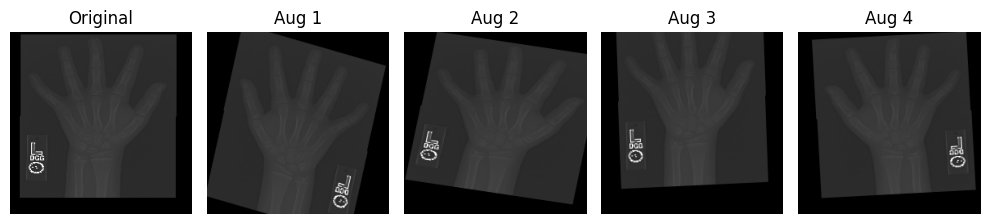

In [37]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np

# Setup basic augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Display sample original and augmented
img_path = os.path.join(image_dir, df['id'][0])
img = load_img(img_path, target_size=(224, 224))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

plt.figure(figsize=(10, 5))
plt.subplot(1, 5, 1)
plt.imshow(img)
plt.title("Original")
plt.axis('off')

i = 2
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(1, 5, i)
    plt.imshow(batch[0].astype('uint8'))
    plt.title(f'Aug {i-1}')
    plt.axis('off')
    i += 1
    if i > 5:
        break

plt.tight_layout()
plt.show()


In [38]:
from sklearn.model_selection import train_test_split

# Split the dataframe
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Use regression, so convert target to string temporarily
train_df['boneage'] = train_df['boneage'].astype(str)
val_df['boneage'] = val_df['boneage'].astype(str)

# Rescale and augment
train_gen = datagen.flow_from_dataframe(
    train_df,
    directory=image_dir,
    x_col='id',
    y_col='boneage',
    target_size=(224, 224),
    batch_size=8,
    class_mode='raw'  # for regression
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    val_df,
    directory=image_dir,
    x_col='id',
    y_col='boneage',
    target_size=(224, 224),
    batch_size=8,
    class_mode='raw'
)


Found 32 validated image filenames.
Found 9 validated image filenames.


In [41]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4448739.0000 - mae: 1148.0994

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 4436699.0000 - mae: 1178.3218 - val_loss: 26614.5781 - val_mae: 161.7974
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 145263.5000 - mae: 329.0050 - val_loss: 26075.0059 - val_mae: 160.0704
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 28723.4512 - mae: 124.1647 - val_loss: 26178.1016 - val_mae: 160.4023
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 9607.3330 - mae: 77.5125 - val_loss: 26224.6992 - val_mae: 160.5526
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 10460.7539 - mae: 83.8039 - val_loss: 26199.8906 - val_mae: 160.4726
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 8512.3340 - mae: 74.8313 - val_loss: 26155.1660 - val_mae: 160.3298
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 5996.4155 - mae: 62.8837 - val_loss: 26156.2598 - val_mae: 160.3327
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 7565.6162 - mae: 70.5510 - val_loss: 26174.8652 - val_mae: 160.3914
Epoch 9/10
4/4

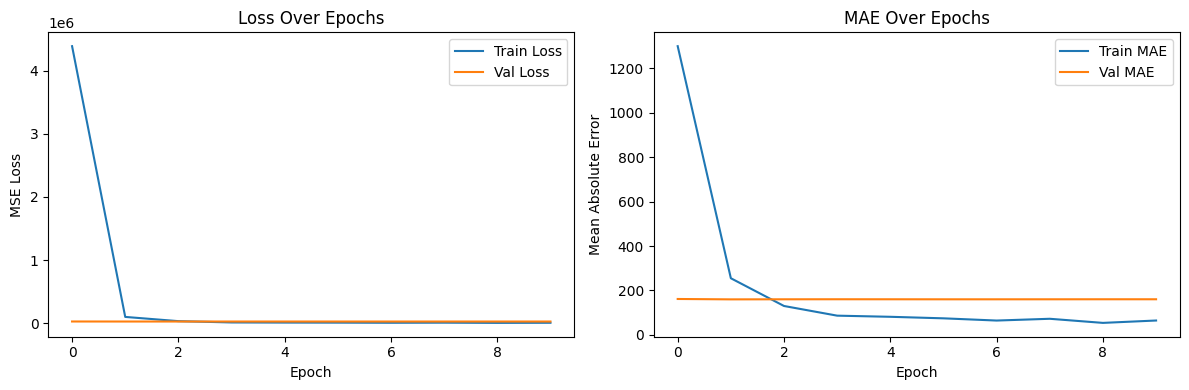

In [42]:
import matplotlib.pyplot as plt

# Plot loss and MAE
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()


In [43]:
# Evaluate on validation set
val_loss, val_mae = model.evaluate(val_gen)
print(f"Validation Loss: {val_loss:.2f}, Validation MAE: {val_mae:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 26292.0977 - mae: 160.7038 
Validation Loss: 26211.44, Validation MAE: 160.51


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


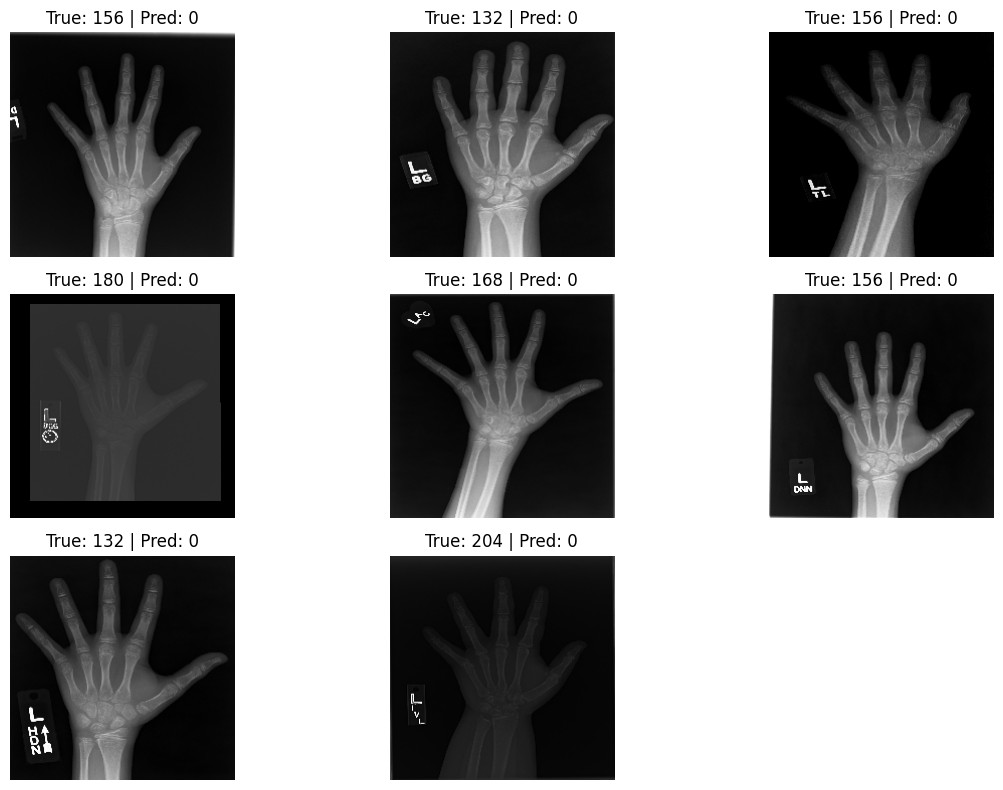

In [44]:
import numpy as np

# Get batch from validation generator
images, labels = next(val_gen)

# Predict
preds = model.predict(images)

# Plot predictions
plt.figure(figsize=(12, 8))
for i in range(min(9, len(images))):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(f"True: {int(labels[i])} | Pred: {int(preds[i][0])}")
    plt.axis('off')
plt.tight_layout()
plt.show()